<a href="https://colab.research.google.com/github/azu07/Hybrid---Siamese-Network-and-Chaotic-Visual-Cryptography-/blob/main/new_siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.models import Model
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from tensorflow.keras.layers import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
#from fr_utils import *
#from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

np.set_printoptions(threshold=np.inf, linewidth=np.nan)

In [ ]:
import os
data_path = os.path.join('/content/gdrive/MyDrive/MIT-CBCL-facerec-database')
train_folder = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
from google.colab import files

Mounted at /content/gdrive


In [ ]:
base_class_name = 'character'

In [ ]:
import cv2
img = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/0000_00000001.jpg')
print("Each image in the data set has a same of {0}".format(img.shape))
flattened_img = img.flatten()

print("The number of features in any image from the data set are: {0}".format(flattened_img.shape[0]))

Each image in the data set has a same of (576, 768, 3)
The number of features in any image from the data set are: 1327104


In [ ]:
def gen_class_names(base_class_name):
    classes = []
    for i in range(1,21):
        if i < 10:
            classes.append("{0}0{1}".format(base_class_name, i))
        else:
            classes.append("{0}{1}".format(base_class_name, i))
    return classes

classes = gen_class_names(base_class_name)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

labels = generate_one_hot_encoding(classes)

**Siamese Network**

In [ ]:
def initialize_weights(shape, dtype=None):
  return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
  return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

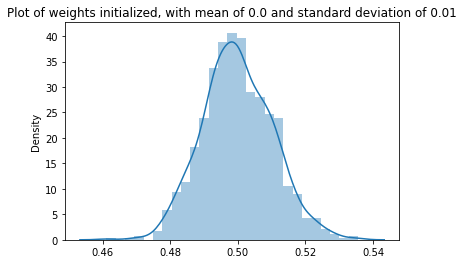

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

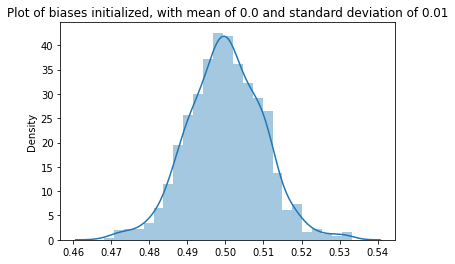

In [ ]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [ ]:
import pathlib
dataset_url = "file:///content/gdrive/MyDrive/MIT-CBCL-facerec-database/training-originals/10/0000_00000001.jpg"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='training-originals',
                                   untar=True)
data_dir = pathlib.Path(data_dir)


204800/189841 [================================] - 0s 0us/step


<**Converting .pgm files to .png files and storing them in a new file called new_test**>

In [ ]:
'''
import os
from PIL import Image

for file in os.listdir('/content/gdrive/MyDrive/MIT-CBCL-facerec-database/test'):
    filename, extension  = file.split('.')
    if extension == "pgm":
        new_file = "{}.png".format(filename)
        with Image.open(os.path.join('/content/gdrive/MyDrive/MIT-CBCL-facerec-database/test',file)) as im:
            im.save(os.path.join('/content/gdrive/MyDrive/MIT-CBCL-facerec-database/new_test',new_file))

'''

'\nimport os\nfrom PIL import Image\n\nfor file in os.listdir(\'/content/gdrive/MyDrive/MIT-CBCL-facerec-database/test\'):\n    filename, extension  = file.split(\'.\')\n    if extension == "pgm":\n        new_file = "{}.png".format(filename)\n        with Image.open(os.path.join(\'/content/gdrive/MyDrive/MIT-CBCL-facerec-database/test\',file)) as im:\n            im.save(os.path.join(\'/content/gdrive/MyDrive/MIT-CBCL-facerec-database/new_test\',new_file))\n\n'

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/MIT-CBCL-facerec-database/training-originals',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 59 files belonging to 10 classes.


In [ ]:
class_names = train.class_names
print(class_names)

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


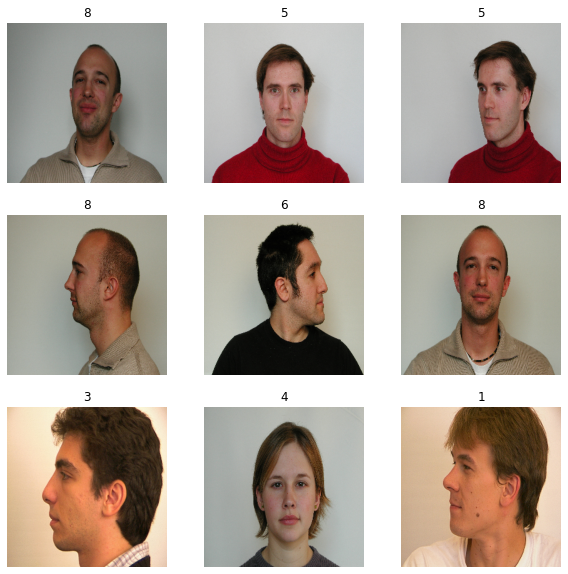

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_wholeimage = []
train_wholelabel = []

for images, labels in train.unbatch().take(-1):
    train_wholeimage.append(images)
    train_wholelabel.append(labels)

In [ ]:
train_wholelabel= np.asarray(train_wholelabel, dtype=np.float32)
train_wholeimage = np.asarray(train_wholeimage, dtype=np.float32)
train_wholelabel.shape

(59,)

In [ ]:
train_wholeimage.shape

(59, 256, 256, 3)

In [ ]:
#Testing using new_test folder
val = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/MIT-CBCL-facerec-database/new_test',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 866 files belonging to 10 classes.


In [ ]:
val_wholeimage = []
val_wholelabel = []

for images, labels in val.unbatch().take(-1):
    val_wholeimage.append(images)
    val_wholelabel.append(labels)

In [ ]:
val_wholelabel= np.asarray(val_wholelabel, dtype=np.float32)
val_wholeimage = np.asarray(val_wholeimage, dtype=np.float32)
val_wholelabel.shape

(866,)

In [ ]:
val_wholeimage.shape

(866, 256, 256, 3)

In [ ]:
import random

In [ ]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
train_wholelabel = train_wholelabel.astype("uint8")
val_wholelabel = val_wholelabel.astype("uint8")

In [ ]:
pairs_train, labels_train = make_pairs(train_wholeimage, train_wholelabel)
pairs_val, labels_val = make_pairs(val_wholeimage, val_wholelabel)

In [ ]:
pairs_train.shape

(118, 2, 256, 256, 3)

In [ ]:
pairs_val.shape

(1732, 2, 256, 256, 3)

In [ ]:
labels_train.shape

(118,)

In [ ]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

In [ ]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

In [ ]:
IMG_SHAPE = x_train_1.shape[1:]
IMG_SHAPE

(256, 256, 3)

In [ ]:
inputx = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.Conv2D(filters=4, kernel_size=3, padding='valid', activation="relu")(inputx)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='valid', activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters=4, kernel_size=3, padding='valid', activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(500, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)

embedding_network = tf.keras.Model(inputx, x)



In [ ]:
!pip3 install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=eda31e43f52244c3f8081e9f42ea1f8d607f97eefa579adf738bf534847296b0
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
import keras.utils

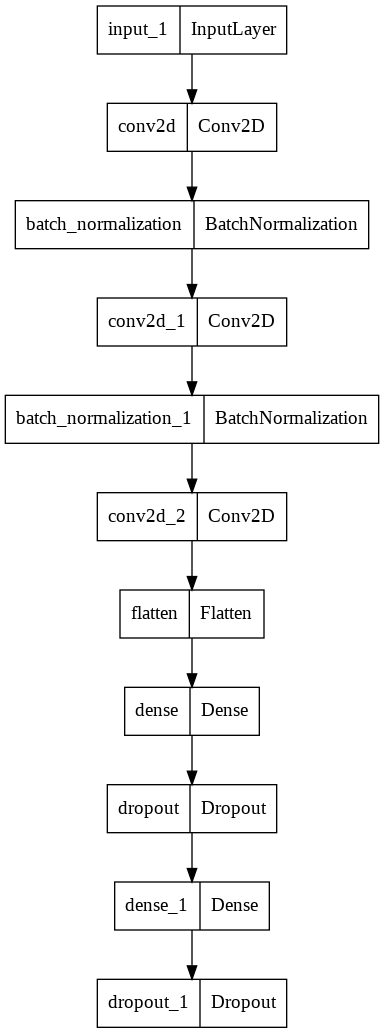

In [ ]:
from keras.utils import vis_utils
from keras.utils.vis_utils import plot_model

keras.utils.vis_utils.plot_model(model = embedding_network)




In [ ]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
input_1 = tf.keras.layers.Input(IMG_SHAPE)
input_2 = tf.keras.layers.Input(IMG_SHAPE)

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
margin = 1

In [ ]:
siamese.save('model.h5')

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
siamese.load_weights(checkpoint_filepath)

NotFoundError: ignored

In [ ]:
#siamese=get_siamese_model((105 , 105, 1))
opt = tf.keras.optimizers.Adamax(learning_rate=1e-4)
siamese.compile(loss=loss(margin=margin), optimizer=opt, metrics=["accuracy"]) 
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 5)            125003753   ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data= ([x_train_1[:10], x_val_1[:10]], labels_train[:10]),
    batch_size = 16,
    epochs = 5,
)    

Epoch 1/5
8/8 [==============================] - 15s 206ms/step - loss: 0.2597 - accuracy: 0.5000 - val_loss: 0.3260 - val_accuracy: 0.5000
Epoch 2/5
8/8 [==============================] - 1s 103ms/step - loss: 0.2577 - accuracy: 0.5339 - val_loss: 0.2919 - val_accuracy: 0.5000
Epoch 3/5
8/8 [==============================] - 1s 105ms/step - loss: 0.2568 - accuracy: 0.5169 - val_loss: 0.2773 - val_accuracy: 0.5000
Epoch 4/5
8/8 [==============================] - 1s 104ms/step - loss: 0.2516 - accuracy: 0.5085 - val_loss: 0.2744 - val_accuracy: 0.5000
Epoch 5/5
8/8 [==============================] - 1s 103ms/step - loss: 0.2356 - accuracy: 0.6441 - val_loss: 0.2668 - val_accuracy: 0.5000


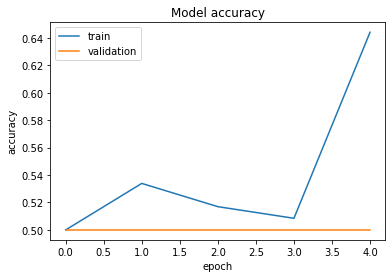

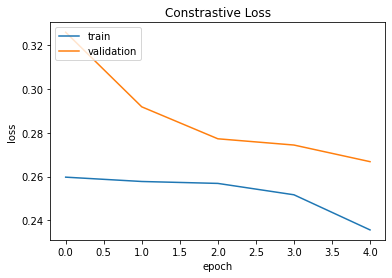

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [ ]:
results = siamese.evaluate([x_val_1[:30], x_val_2[:30]], labels_val[:30]) #suppose is x_test_1
print("test loss, test acc:", results)

1/1 [==============================] - 0s 436ms/step - loss: 0.2528 - accuracy: 0.5000
test loss, test acc: [0.2528046667575836, 0.5]


In [ ]:
print("test accuracy :", results[1]*100, "%")

test accuracy : 50.0 %


In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1)) #, cmap="gray")
        pairs[i][0] = pairs[i][0]/251
        pairs[i][1] = pairs[i][1]/251
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("False: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [ ]:
pairs_val.shape

In [ ]:
predictions = siamese.predict([x_val_1[:10], x_val_2[:10]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


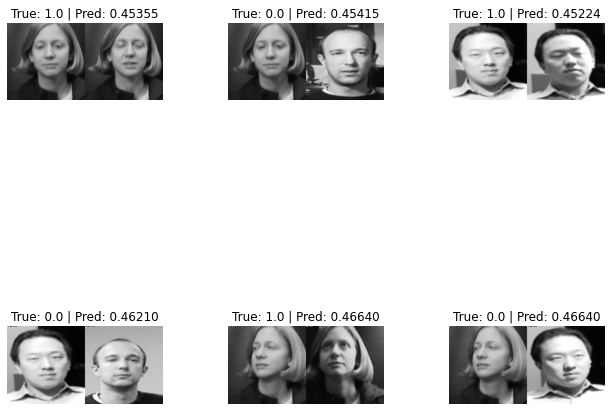

In [ ]:
visualize(pairs_val, labels_val,predictions=predictions, test=True)

In [ ]:
siamese.save('model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('model.h5', compile=False)
loaded_model.layers[0].input_shape

[(None, 256, 256, 3)]

In [ ]:
#pred = loaded_model.predict([x_val_1[30:60], x_val_2[30:60]])


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
siamese.compile(loss=loss(margin=margin), optimizer=opt, metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data= ([x_val_1[:60], x_val_2[:60]], labels_val[:60]),
    batch_size = 16,
    epochs = 5,
)    

Epoch 1/5
8/8 [==============================] - 4s 324ms/step - loss: 0.2502 - precision: 0.6122 - recall: 0.5085 - val_loss: 0.2534 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
8/8 [==============================] - 1s 115ms/step - loss: 0.2637 - precision: 0.5217 - recall: 0.4068 - val_loss: 0.2534 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
8/8 [==============================] - 1s 114ms/step - loss: 0.2578 - precision: 0.6000 - recall: 0.4068 - val_loss: 0.2536 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
8/8 [==============================] - 1s 116ms/step - loss: 0.2329 - precision: 0.6444 - recall: 0.4915 - val_loss: 0.2541 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
8/8 [==============================] - 1s 114ms/step - loss: 0.2620 - precision: 0.5000 - recall: 0.3220 - val_loss: 0.2544 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
